In [1]:
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so
import os
import io

import random

random.seed(42)

In [2]:
# set fixed order of elements in graphs
optimization_order = ['disabled', 'enabled']
service_mesh_order = ['none', 'cilium', 'istio-ambient', 'istio-sidecar']

In [3]:
def count_decimal_places(num, *, remove_single_zero=False):
    str_num = str(num)
    if remove_single_zero and str_num.endswith('.0'):
        return 0
    if '.' in str_num:
        return len(str_num) - str_num.index('.') - 1
    else:
        return 0

In [39]:
def format_data_size(number, from_unit, to_unit, *, remove_single_decimal_zero=False):
    convert_table = {
        'B': 1,
        'K': 1000,
        'M': 1000 ** 2,
        'G': 1000 ** 3,
        'T': 1000 ** 4,
        'P': 1000 ** 5,
    }
    if from_unit[-1] == 'B' and to_unit[-1] == 'b':
        number *= 8
    if from_unit[-1] == 'b' and to_unit[-1] == 'B':
        number /= 8
    number *= convert_table[from_unit[0].upper()]
    number /= convert_table[to_unit[0].upper()]
    return '{:.{}f}'.format(number, min(count_decimal_places(number, remove_single_zero=True), pd.get_option('display.precision')))

In [40]:
def format_time(number, from_unit, to_unit, remove_single_decimal_zero=False):
    convert_table = {
        'ns': 1,
        'us': 10 ** 3,
        'ms': 10 ** 6,
         's': 10 ** 9,
    }
    number *= convert_table[from_unit]
    number /= convert_table[to_unit]
    return '{:.{}f}'.format(number, min(count_decimal_places(number, remove_single_zero=True), pd.get_option('display.precision')))

In [103]:
pd.set_option('display.precision', 1)
float_format = lambda x: '{:.{}f}'.format(x, min(count_decimal_places(x), pd.get_option('display.precision')))
#pd.set_option('display.float_format', float_format)
pd.set_option('display.max_columns', None)

In [94]:
def print_latex(df):
    df = df.copy()
    df.index = pd.MultiIndex.from_tuples([(f'\\textit{{{a}}}' if a == 'none' else f'\\texttt{{{a}}}', b) for (a, b) in df.index], names=['service_mesh', 'optimization'])
    print(df.to_latex(float_format=float_format))

In [7]:
import os
import re
import zipfile
from pprint import pprint


def logs_processing(basepath='.'):
    files = os.listdir(basepath)
    logs_zip_pattern = re.compile(r'logs_.*\.zip')
    logs_zip_files = [f for f in files if logs_zip_pattern.match(f)]

    workload_log_map = {
        'ping': 'ping-echo',
        'client': 'file-transfer',
        'memtier': 'redis',
    }

    system_logs = []
    workload_logs = {}

    for zip_filename in logs_zip_files:
        zip_filename_components = zip_filename.split('.')[0].split('_')

        if len(zip_filename_components) != 4: continue

        _, cni, service_mesh, optimization = zip_filename_components

        with zipfile.ZipFile(os.path.join(basepath, zip_filename), 'r') as zip_ref:
            for file in zip_ref.infolist():
                if file.is_dir(): continue

                entry = { 'cni': cni, 'service_mesh': service_mesh, 'optimization': optimization, 'workload': None, 'data': None, 'meta': {} }

                filename = file.filename.replace(r'mnt/logs/', '')

                ###################
                ### system logs ###
                ###################

                ### statexec
                if filename.startswith('statexec_metrics'):
                    entry['workload'] = filename.split('_')[2]

                    data = zip_ref.read(file).decode('utf-8')
                    statexec_pattern = re.compile(r'(?P<metric>.*){(?P<params>.*?)} (?P<value>.+) (?P<timestamp>\d+)')
                    statexec_param_pattern = re.compile(r',?(?P<k>.*?)="(?P<v>.*?)"')
                    data = [statexec_pattern.match(line).groupdict() for line in data.split('\n') if line != '' and line[0] != '#']
                    data = [{**value, 'params': { k: v for (k, v) in statexec_param_pattern.findall(value['params']) if k not in ['instance', 'job', 'role', 'cni', 'optimization', 'service_mesh'] } } for value in data ]
                    entry['data'] = data

                    system_logs.append(entry)
                    continue


                #####################
                ### workload logs ###
                #####################

                entry['workload'] = workload_log_map.get(filename.split('/')[0], None)

                if entry['workload'] == 'ping-echo':
                    data = zip_ref.read(file).decode('utf-8')
                    entry['data'] = data

                elif entry['workload'] == 'file-transfer':
                    data = zip_ref.read(file).decode('utf-8')
                    values = re.findall(r'Ncat: \d+ bytes sent, \d+ bytes received in (\d+.\d+) seconds\.', data)
                    entry['data'] = [float(v) * (10 ** 9) for v in values]

                elif entry['workload'] == 'redis':
                    if filename.endswith('/log.txt'):
                        entry['meta'] = { 'type': 'metrics' }
                        data = zip_ref.read(file).decode('utf-8')
                        data = data.replace(r'Connection error: Connection refused', '')
                        redis_log_pattern = re.compile(r'\[RUN #(?P<iteration>\d+) 100%, *(?P<took>\d+) secs\] *0 threads: *\d+ ops, *\d+ \(avg: *(?P<ops_avg>\d+)\) ops\/sec, *\d+.\d+[KMG]B\/sec \(avg: *(?P<throughput_avg>\d+.\d+[KMG]B)\/sec\), *\d+.\d+ \(avg: *(?P<latency_avg>\d+.\d+)\) msec latency')
                        values = [match.groupdict() for match in redis_log_pattern.finditer(data)]
                        for value in values:
                            # took is in s. transform to ns
                            value['took'] = int(value['took']) * (10 ** 9)

                            # latency_avg is in ms. transform to ns
                            value['latency_avg'] = float(value['latency_avg']) * (10 ** 6)

                            # throughput_avg is in KB, MB, GB. transform to bits
                            # https://github.com/RedisLabs/memtier_benchmark/blob/2.1.2/memtier_benchmark.cpp#L1121
                            B = float(value['throughput_avg'][:-2])
                            # memtier uses 1024 to multiply between units KB, MB, GB. transform to bytes
                            unit = value['throughput_avg'][-2:]
                            if unit == 'GB':
                                B *= 1024 ** 3
                            elif unit == 'MB':
                                B *= 1024 ** 2
                            elif unit == 'KB':
                                B *= 1024
                            # memtier uses bytes. transform to bits
                            B *= 8
                            value['throughput_avg'] = B
                        entry['data'] = values
                    else:
                        match = re.match(r'_FULL_RUN_(?P<iteration>\d+)\.txt$', filename.split('/')[-1])

                        if not match: continue

                        iteration = match.group('iteration')
                        entry['meta'] = { 'type': 'histogram', 'iteration': iteration }
                        data = zip_ref.read(file).decode('utf-8')
                        entry['data'] = '\n'.join([line for line in data.split('\n') if line != '' and line[0] != '#'][:-1])

                ### UNKNOWN
                else:
                    continue

                if entry['workload'] not in workload_logs:
                    workload_logs[entry['workload']] = []

                workload_logs[entry['workload']].append(entry)

    return { 'system_logs': system_logs, 'workload_logs': workload_logs }

In [8]:
logs = logs_processing('../workloads/')

In [9]:
system_logs = pd.DataFrame(logs['system_logs'])
del system_logs['meta']
system_logs = system_logs.explode('data').apply(lambda x: pd.concat([x.drop('data'), pd.json_normalize(x.data, sep='_').iloc[0]]), axis=1)
system_logs = system_logs.astype({'timestamp': 'int64', 'value': 'float64'}).sort_values(by='timestamp', ignore_index=True)

In [10]:
system_logs.head()

,cni,metric,optimization,params_cpu,params_disk,params_interface,params_mode,service_mesh,timestamp,value,workload
0,calico,statexec_cpu_seconds_total,disabled,cpu1,NaN,NaN,guest,none,1736354149117,0.00e+00,ping-echo
1,calico,statexec_cpu_seconds_total,disabled,cpu1,NaN,NaN,guestNice,none,1736354149117,0.00e+00,ping-echo
2,calico,statexec_network_sent_bytes_total,disabled,NaN,NaN,calib5d19d16696,NaN,none,1736354149117,1.47e+06,ping-echo
3,calico,statexec_network_received_bytes_total,disabled,NaN,NaN,calib5d19d16696,NaN,none,1736354149117,1.23e+06,ping-echo
4,calico,statexec_network_sent_bytes_total,disabled,NaN,NaN,cali61add15868f,NaN,none,1736354149117,4.65e+05,ping-echo


In [11]:
system_logs.timestamp.diff().abs().sort_values(ascending=False)[:25]

268618    1.86e+08
221306    6.71e+05
48864     5.61e+05
161484    2.23e+05
247472    2.06e+05
109972    1.70e+05
28990     1.63e+05
198830    1.14e+05
128552    7.30e+04
77652     6.46e+04
85408     6.18e+04
8774      5.77e+04
212580    5.67e+04
35186     5.33e+04
183064    5.26e+04
15744     5.25e+04
260336    5.19e+04
40864     5.08e+04
237484    5.06e+04
230378    5.03e+04
173394    4.82e+04
254042    4.79e+04
135868    4.70e+04
206200    4.65e+04
242786    1.00e+03
Name: timestamp, dtype: float64

In [12]:
system_logs['x'] = (system_logs.timestamp.diff().abs().gt(40_000).cumsum() + 1).astype(str)
start_point = system_logs.groupby('x')['timestamp'].transform(lambda x: x.min())
system_logs['timestamp_start'] = system_logs.timestamp - start_point

In [13]:
system_logs

,cni,metric,optimization,params_cpu,params_disk,params_interface,params_mode,service_mesh,timestamp,value,workload,x,timestamp_start
0,calico,statexec_cpu_seconds_total,disabled,cpu1,NaN,NaN,guest,none,1736354149117,0.00e+00,ping-echo,1,0
1,calico,statexec_cpu_seconds_total,disabled,cpu1,NaN,NaN,guestNice,none,1736354149117,0.00e+00,ping-echo,1,0
2,calico,statexec_network_sent_bytes_total,disabled,NaN,NaN,calib5d19d16696,NaN,none,1736354149117,1.47e+06,ping-echo,1,0
3,calico,statexec_network_received_bytes_total,disabled,NaN,NaN,calib5d19d16696,NaN,none,1736354149117,1.23e+06,ping-echo,1,0
4,calico,statexec_network_sent_bytes_total,disabled,NaN,NaN,cali61add15868f,NaN,none,1736354149117,4.65e+05,ping-echo,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
271585,calico,statexec_disk_read_bytes_total,both,NaN,sda1,NaN,NaN,none,1736545863899,2.92e+08,none,25,33000
271586,calico,statexec_disk_read_bytes_total,both,NaN,sda,NaN,NaN,none,1736545863899,3.13e+08,none,25,33000
271587,calico,statexec_disk_write_bytes_total,both,NaN,loop0,NaN,NaN,none,1736545863899,0.00e+00,none,25,33000
271588,calico,statexec_disk_read_bytes_total,both,NaN,loop0,NaN,NaN,none,1736545863899,1.43e+04,none,25,33000


In [14]:
memory_used_bytes = system_logs[system_logs.metric.eq('statexec_memory_used_bytes')]
memory_used_percent = system_logs[system_logs.metric.eq('statexec_memory_used_percent')]

In [17]:
sorted(system_logs.metric.unique())

['statexec_command_status',
 'statexec_cpu_seconds_total',
 'statexec_disk_read_bytes_total',
 'statexec_disk_write_bytes_total',
 'statexec_memory_available_bytes',
 'statexec_memory_buffers_bytes',
 'statexec_memory_cached_bytes',
 'statexec_memory_free_bytes',
 'statexec_memory_total_bytes',
 'statexec_memory_used_bytes',
 'statexec_memory_used_percent',
 'statexec_metric_collect_duration_ms',
 'statexec_network_received_bytes_total',
 'statexec_network_sent_bytes_total',
 'statexec_statexec_time_since_start_ms',
 'statexec_summary_cpu_cores',
 'statexec_summary_cpu_mean_seconds',
 'statexec_summary_disk_mean_read_bytes_per_second',
 'statexec_summary_disk_mean_write_bytes_per_second',
 'statexec_summary_memory_buffers_bytes',
 'statexec_summary_memory_cached_bytes',
 'statexec_summary_memory_free_bytes',
 'statexec_summary_memory_total_bytes',
 'statexec_summary_memory_used_bytes',
 'statexec_summary_network_mean_received_bytes_per_second',
 'statexec_summary_network_mean_sent_byte

In [18]:
sorted(system_logs[system_logs.metric.eq('statexec_cpu_seconds_total')].params_mode.unique())

['guest',
 'guestNice',
 'idle',
 'iowait',
 'irq',
 'nice',
 'softirq',
 'steal',
 'system',
 'user']

In [19]:
system_logs[system_logs.metric.eq('statexec_cpu_seconds_total')]

,cni,metric,optimization,params_cpu,params_disk,params_interface,params_mode,service_mesh,timestamp,value,workload,x,timestamp_start
0,calico,statexec_cpu_seconds_total,disabled,cpu1,NaN,NaN,guest,none,1736354149117,0.00,ping-echo,1,0
1,calico,statexec_cpu_seconds_total,disabled,cpu1,NaN,NaN,guestNice,none,1736354149117,0.00,ping-echo,1,0
14,calico,statexec_cpu_seconds_total,disabled,cpu1,NaN,NaN,system,none,1736354149117,61.57,ping-echo,1,0
15,calico,statexec_cpu_seconds_total,disabled,cpu1,NaN,NaN,nice,none,1736354149117,0.00,ping-echo,1,0
18,calico,statexec_cpu_seconds_total,disabled,cpu3,NaN,NaN,softirq,none,1736354149117,4.74,ping-echo,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
271576,calico,statexec_cpu_seconds_total,both,cpu0,NaN,NaN,steal,none,1736545863899,7.56,none,25,33000
271577,calico,statexec_cpu_seconds_total,both,cpu0,NaN,NaN,idle,none,1736545863899,526.60,none,25,33000
271578,calico,statexec_cpu_seconds_total,both,cpu0,NaN,NaN,user,none,1736545863899,93.94,none,25,33000
271583,calico,statexec_cpu_seconds_total,both,cpu1,NaN,NaN,irq,none,1736545863899,0.00,none,25,33000


In [20]:
system_logs[system_logs.metric.eq('statexec_cpu_seconds_total')].groupby(['params_mode', 'params_cpu'])['value'] \
.agg(
    count='count',
    nunique=lambda x: x.nunique(),
    first='first',
    last='last',
    is_increasing=lambda x: all(x.iloc[i] <= x.iloc[i + 1] for i in range(len(x) - 1)),
    is_decreasing=lambda x: all(x.iloc[i] >= x.iloc[i + 1] for i in range(len(x) - 1)),
)

count  nunique    first    last  is_increasing  \
params_mode params_cpu                                                   
guest       cpu0         3076        1     0.00    0.00           True   
            cpu1         3076        1     0.00    0.00           True   
            cpu2         3076        1     0.00    0.00           True   
            cpu3         3076        1     0.00    0.00           True   
guestNice   cpu0         3076        1     0.00    0.00           True   
            cpu1         3076        1     0.00    0.00           True   
            cpu2         3076        1     0.00    0.00           True   
            cpu3         3076        1     0.00    0.00           True   
idle        cpu0         3076     3052  1004.07  526.60          False   
            cpu1         3076     3050  1004.64  539.25          False   
            cpu2         3076     3050  1002.48  536.58          False   
            cpu3         3076     3051  1008.27  541.04          False   
iowait      cpu0         3076     1462    11.36   10.53          False   
            cpu1         3076     1360    11.91   11.43          False   
            cpu2         3076     1326    11.48   11.89          False   
            cpu3         3076     1394    10.52   10.61          False   
irq         cpu0         3076        1     0.00    0.00           True   
            cpu1         3076        1     0.00    0.00           True   
            cpu2         3076        1     0.00    0.00           True   
            cpu3         3076        1     0.00    0.00           True   
nice        cpu0         3076        3     0.00    2.90           True   
            cpu1         3076        1     0.00    0.00           True   
            cpu2         3076        3     0.00    0.01          False   
            cpu3         3076        1     0.00    0.00           True   
softirq     cpu0         3076     2071     6.96    3.24          False   
            cpu1         3076     1927     5.52    2.63          False   
            cpu2         3076     1839     4.64    2.36          False   
            cpu3         3076     1841     4.74    2.69          False   
steal       cpu0         3076     2333    12.97    7.56          False   
            cpu1         3076     2293    13.04    7.32          False   
            cpu2         3076     2231    13.38    7.56          False   
            cpu3         3076     2256    12.57    7.75          False   
system      cpu0         3076     3035    61.48   39.05          False   
            cpu1         3076     3033    61.57   37.18          False   
            cpu2         3076     3026    61.50   37.01          False   
            cpu3         3076     3021    62.41   36.31          False   
user        cpu0         3076     3041   156.02   93.94          False   
            cpu1         3076     3046   155.00   84.03          False   
            cpu2         3076     3041   158.03   86.55          False   
            cpu3         3076     3043   152.29   82.92          False   

                        is_decreasing  
params_mode params_cpu                 
guest       cpu0                 True  
            cpu1                 True  
            cpu2                 True  
            cpu3                 True  
guestNice   cpu0                 True  
            cpu1                 True  
            cpu2                 True  
            cpu3                 True  
idle        cpu0                False  
            cpu1                False  
            cpu2                False  
            cpu3                False  
iowait      cpu0                False  
            cpu1                False  
            cpu2                False  
            cpu3                False  
irq         cpu0                 True  
            cpu1                 True  
            cpu2                 True  
            cpu3                 True  
nice        cpu0                Fal

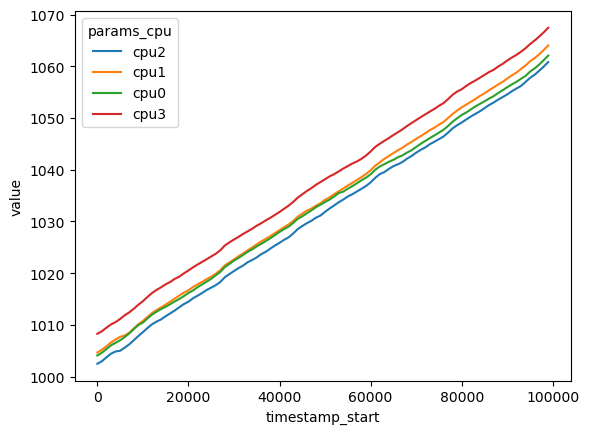

In [21]:
# 4, 5, 22
g = sns.lineplot(data=system_logs[
    system_logs.metric.eq('statexec_cpu_seconds_total') &
    system_logs.params_mode.isin(['idle']) &
    system_logs.x.isin(['1'])
], x='timestamp_start', y='value', hue='params_cpu')

#g.legend(loc='center right')

# none

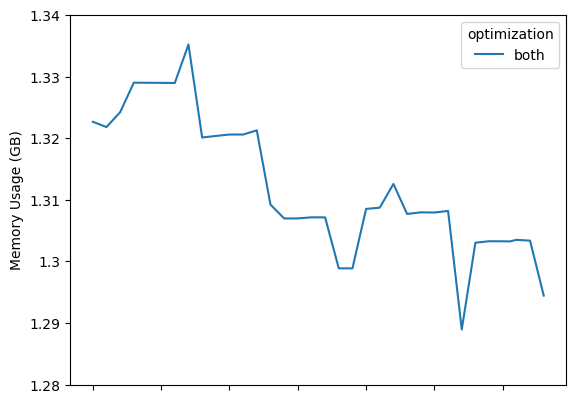

In [24]:
g = sns.lineplot(data=memory_used_bytes[memory_used_bytes.workload.eq('none')], y='value', x='timestamp_start', hue='optimization')

g.set_yticks(g.get_yticks().tolist())
g.set(
    xlabel='',
    ylabel='Memory Usage (GB)',
    yticklabels=[format_data_size(tick, 'B', 'GB') for tick in g.get_yticks()],
    xticklabels=[],
);

#g.legend.set(title='Optimization', loc='upper right')
#g.get_legend().set_visible(False)

# file-transfer

In [114]:
file_transfer = pd.DataFrame(logs['workload_logs']['file-transfer'])
del file_transfer['meta']
file_transfer.rename(columns={'data': 'took'}, inplace=True)
file_transfer = file_transfer.explode('took', ignore_index=True).astype({'took': 'int64'})

In [206]:
file_transfer.head()

,cni,service_mesh,optimization,workload,took
0,calico,istio-ambient,disabled,file-transfer,10660000000
1,calico,istio-ambient,disabled,file-transfer,10860000000
2,calico,istio-ambient,disabled,file-transfer,10590000000
3,calico,istio-ambient,disabled,file-transfer,10350000000
4,calico,istio-ambient,disabled,file-transfer,10440000000


In [144]:
summary = memory_used_bytes[memory_used_bytes.workload.eq('file-transfer')].groupby(['service_mesh', 'optimization'])['value'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_data_size(x, 'B', 'MB'))

summary
#print_latex(summary)

p25     p50     avg     p75
service_mesh  optimization                                
cilium        disabled      1283.2  1291.1  1292.7  1302.4
              enabled       1327.3  1332.5  1332.5  1337.0
istio-ambient disabled      1632.2  1647.5  1644.8  1656.8
              enabled       1650.8  1659.0  1660.2  1669.3
istio-sidecar disabled      1614.2  1626.5  1625.4  1637.5
              enabled       1648.9  1660.2  1668.6  1689.6
none          disabled      1354.9  1368.1  1368.0  1379.7
              enabled       1381.3  1392.8  1391.8  1401.5

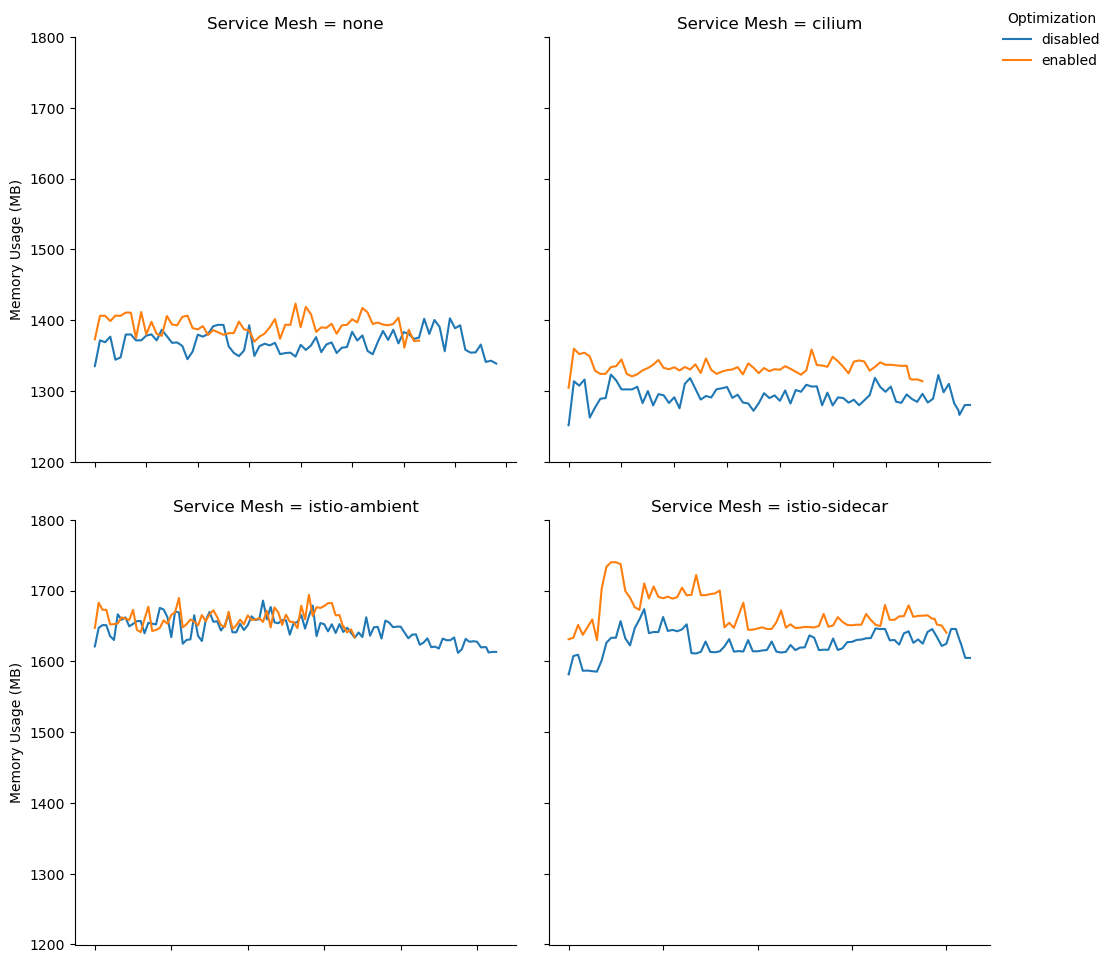

In [85]:
g = sns.relplot(kind='line', data=memory_used_bytes[memory_used_bytes.workload.eq('file-transfer')], y='value', x='timestamp_start', hue='optimization', col='service_mesh', col_order=service_mesh_order, col_wrap=2, facet_kws={'sharey': True, 'sharex': False})

for ax in g.axes:
    ax.set_yticks(ax.get_yticks().tolist())
    ax.set(
        title=ax.get_title().replace('service_mesh', 'Service Mesh'),
        xlabel='',
        ylabel='Memory Usage (MB)',
        yticklabels=[format_data_size(tick, 'B', 'MB') for tick in ax.get_yticks()],
        xticklabels=[],
    )

g.legend.set(title='Optimization', loc='upper right')
#g.get_legend().set_visible(False)
g.figure.savefig('file-transfer-relplot-line-memory-used-bytes.svg', bbox_inches='tight')

In [143]:
summary = file_transfer.groupby(['service_mesh', 'optimization'])['took'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_time(x, 'ns', 's'))

summary
#print_latex(summary)

p25   p50   avg   p75
service_mesh  optimization                        
cilium        disabled       9.3   9.5   9.5   9.6
              enabled        8.3   8.4   8.4   8.4
istio-ambient disabled      10.4  10.6  10.6  10.7
              enabled        8.4   8.5   8.4   8.5
istio-sidecar disabled       6.8   6.9   6.9   6.9
              enabled        8.2   8.3   8.4   8.5
none          disabled      10.5  10.5  10.6  10.7
              enabled        8.3   8.3   8.4   8.4

/tmp/ipykernel_678127/2525828740.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set(


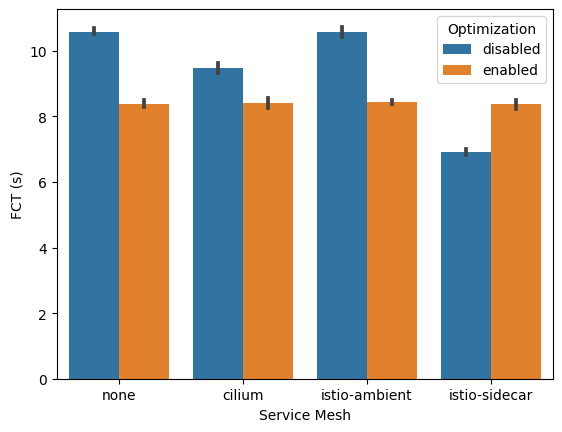

In [775]:
g = sns.barplot(data=file_transfer, y='took', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='FCT (s)',
    yticklabels=[format_time(tick, 'ns', 's') for tick in g.get_yticks()],
)

plt.legend(title='Optimization', loc='upper right')

g.figure.savefig('file-transfer-barplot-fct.svg', bbox_inches='tight')

# ping-echo

In [115]:
ping_echo = pd.DataFrame(logs['workload_logs']['ping-echo'])
del ping_echo['meta']
ping_echo = ping_echo.apply(lambda x: x.drop('data').to_frame().T.join(pd.read_csv(io.StringIO(x.data)), how='cross'), axis=1)
ping_echo = pd.concat(ping_echo.tolist(), ignore_index=True)
ping_echo['latency'] = ping_echo['end'] - ping_echo['start']
ping_echo['throughput'] = (24 * 1e9) / ping_echo['latency']
ping_echo['RPS'] = 1e9 / ping_echo['latency']

In [116]:
ping_echo.head()

,cni,service_mesh,optimization,workload,run,start,end,latency,throughput,RPS
0,calico,istio-ambient,disabled,ping-echo,0,1736357548673463663,1736357548673984875,521212,46046.5,1918.6
1,calico,istio-ambient,disabled,ping-echo,0,1736357548674001489,1736357548674170968,169479,141610.5,5900.4
2,calico,istio-ambient,disabled,ping-echo,0,1736357548674179030,1736357548674310892,131862,182008.5,7583.7
3,calico,istio-ambient,disabled,ping-echo,0,1736357548674326890,1736357548674448536,121646,197293.8,8220.6
4,calico,istio-ambient,disabled,ping-echo,0,1736357548674453871,1736357548674564736,110865,216479.5,9020.0


In [117]:
grouped = ping_echo.groupby(['cni', 'service_mesh', 'optimization', 'workload', 'run'])

In [118]:
ping_echo_extra = grouped.agg(start_min=('start', 'min'), end_max=('end', 'max'))
ping_echo_extra['fct'] = ping_echo_extra['end_max'] - ping_echo_extra['start_min']
ping_echo_extra['jitter'] = grouped[['latency']].std(ddof=0)
ping_echo_extra.reset_index(inplace=True)

In [119]:
ping_echo_extra.head()

,cni,service_mesh,optimization,workload,run,start_min,end_max,fct,jitter
0,calico,istio-ambient,disabled,ping-echo,0,1736357548673463663,1736357563293586211,14620122548,108852.8
1,calico,istio-ambient,disabled,ping-echo,1,1736357565295443961,1736357580060699877,14765255916,99831.8
2,calico,istio-ambient,disabled,ping-echo,2,1736357582062233676,1736357596750912885,14688679209,93902.5
3,calico,istio-ambient,disabled,ping-echo,3,1736357598752148818,1736357613694342945,14942194127,102313.2
4,calico,istio-ambient,disabled,ping-echo,4,1736357615696592734,1736357630437159373,14740566639,103280.0


In [142]:
summary = memory_used_bytes[memory_used_bytes.workload.eq('ping-echo')].groupby(['service_mesh', 'optimization'])['value'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_data_size(x, 'B', 'MB'))

summary
#print_latex(summary)

p25     p50     avg     p75
service_mesh  optimization                                
cilium        disabled      1316.8  1325.1  1325.7  1334.6
              enabled       1345.2  1349.6  1351.8  1360.5
istio-ambient disabled      1652.2  1662.5  1660.7  1673.6
              enabled       1670.0  1679.3  1677.7  1689.7
istio-sidecar disabled      1636.2  1650.7  1645.7  1661.6
              enabled       1663.0  1670.7  1667.6  1678.0
none          disabled      1373.6  1382.6  1380.2  1387.6
              enabled       1404.3  1414.4  1410.6  1422.1

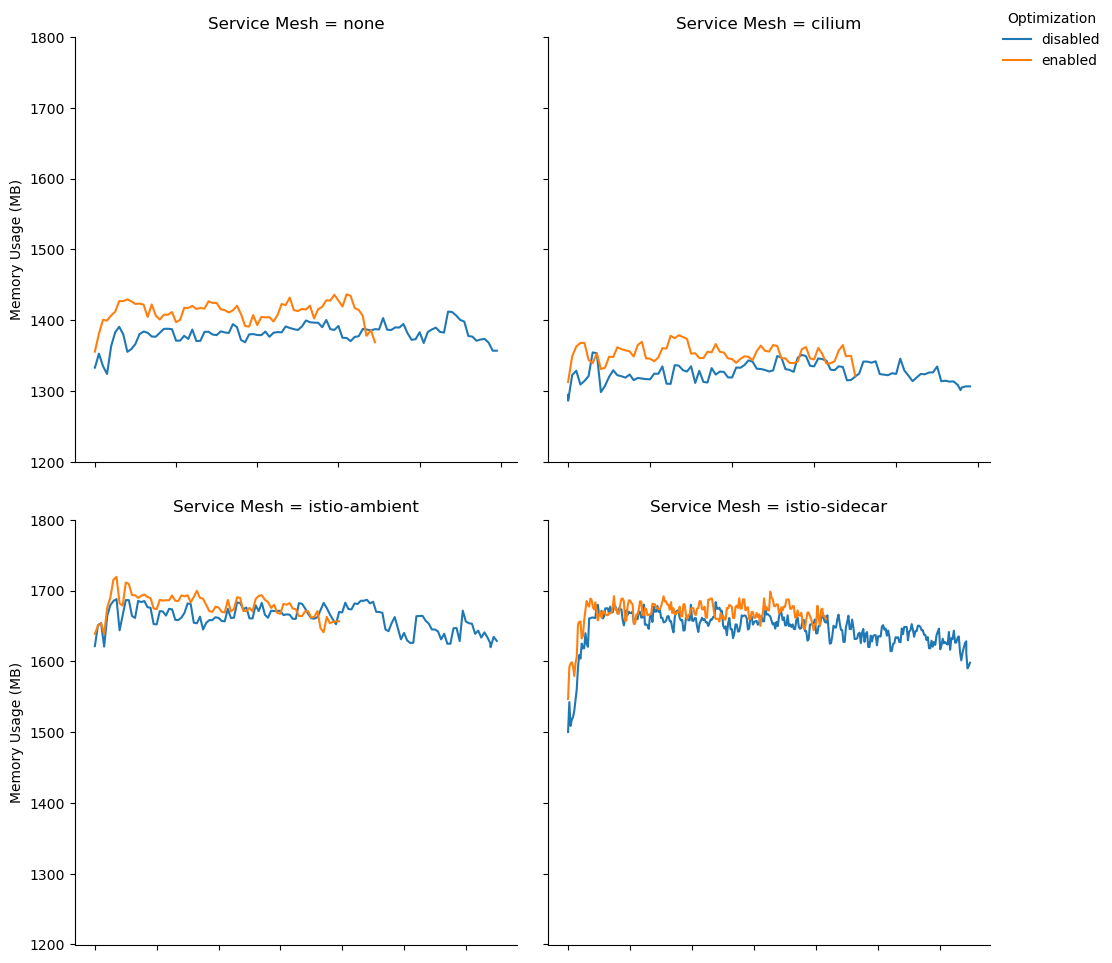

In [79]:
g = sns.relplot(kind='line', data=memory_used_bytes[memory_used_bytes.workload.eq('ping-echo')], y='value', x='timestamp_start', hue='optimization', col='service_mesh', col_order=service_mesh_order, col_wrap=2, facet_kws={'sharey': True, 'sharex': False})

for ax in g.axes:
    ax.set_yticks(ax.get_yticks().tolist())
    ax.set(
        title=ax.get_title().replace('service_mesh', 'Service Mesh'),
        xlabel='',
        ylabel='Memory Usage (MB)',
        yticklabels=[format_data_size(tick, 'B', 'MB') for tick in ax.get_yticks()],
        xticklabels=[],
    )

g.legend.set(title='Optimization', loc='upper right')
#g.get_legend().set_visible(False)
g.figure.savefig('ping-echo-relplot-line-memory-used-bytes.svg', bbox_inches='tight')

In [141]:
summary = ping_echo.groupby(['service_mesh', 'optimization'])['RPS'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
)

summary
#print_latex(summary)

p25      p50      avg      p75
service_mesh  optimization                                    
cilium        disabled       7447.3   9803.7   9685.2  12055.0
              enabled       10275.5  13541.5  13058.0  16422.5
istio-ambient disabled       6303.4   8196.4   8172.3  10124.0
              enabled       10385.2  13808.1  13274.4  16728.0
istio-sidecar disabled       1625.3   2017.9   2049.1   2459.8
              enabled        2781.4   3479.5   3502.1   4235.2
none          disabled       6338.0   8238.7   8186.1  10240.6
              enabled       10260.2  13600.8  13104.6  16514.2

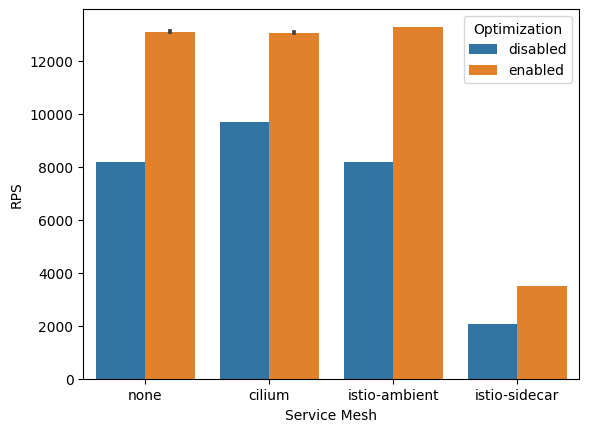

In [595]:
g = sns.barplot(data=ping_echo, y='RPS', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='RPS',
    #yticklabels=[],
)

plt.legend(title='Optimization', loc='upper right')

g.figure.savefig('ping-echo-barplot-rps.svg', bbox_inches='tight')

In [99]:
summary = ping_echo.groupby(['service_mesh', 'optimization'])['throughput'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_data_size(x, 'b', 'KB'))

summary
#print_latex(summary)

p25    p50    avg    p75
service_mesh  optimization                            
cilium        disabled      22.34  29.41  29.06  36.17
              enabled       30.83  40.62  39.17  49.27
istio-ambient disabled      18.91  24.59  24.52  30.37
              enabled       31.16  41.42  39.82  50.18
istio-sidecar disabled       4.88   6.05   6.15   7.38
              enabled        8.34  10.44  10.51  12.71
none          disabled      19.01  24.72  24.56  30.72
              enabled       30.78  40.80  39.31  49.54

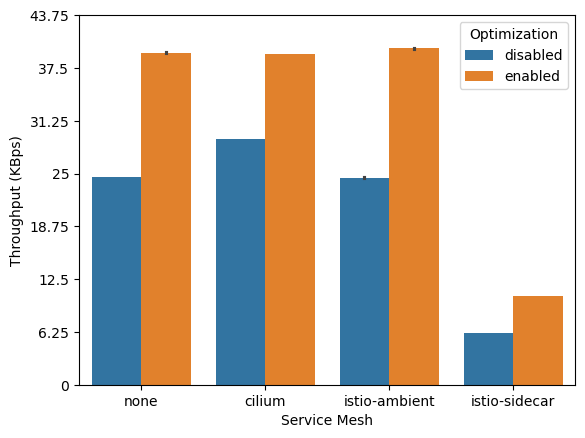

In [193]:
g = sns.barplot(data=ping_echo, y='throughput', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='Throughput (KBps)',
    yticklabels=[format_data_size(tick, 'b', 'KB') for tick in g.get_yticks()],
)

plt.legend(title='Optimization', loc='upper right')

g.figure.savefig('ping-echo-barplot-throughput.svg', bbox_inches='tight')

In [140]:
summary = ping_echo.groupby(['service_mesh', 'optimization'])['latency'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_time(x, 'ns', 'us'))

summary
#print_latex(summary)

p25    p50    avg    p75
service_mesh  optimization                            
cilium        disabled       83.0  102.0  118.5  134.3
              enabled        60.9   73.8   91.4   97.3
istio-ambient disabled       98.8  122.0  140.5  158.6
              enabled        59.8   72.4   91.1   96.3
istio-sidecar disabled      406.5  495.6  551.5  615.3
              enabled       236.1  287.4  320.4  359.5
none          disabled       97.7  121.4  139.8  157.8
              enabled        60.6   73.5   91.2   97.5

/tmp/ipykernel_678127/3329790659.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set(


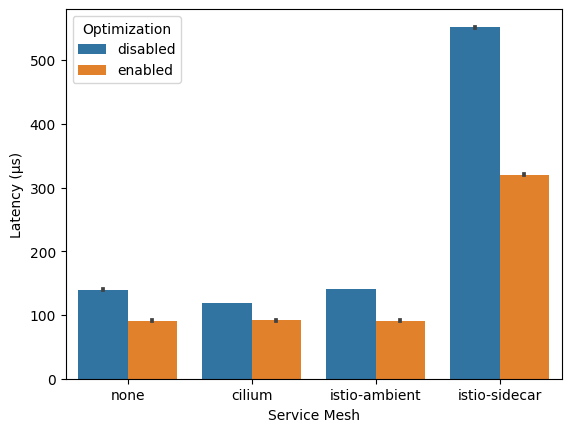

In [593]:
g = sns.barplot(data=ping_echo, y='latency', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='Latency (µs)',
    yticklabels=[format_time(tick, 'ns', 'us') for tick in g.get_yticks()],
)

plt.legend(title='Optimization', loc='upper left')

g.figure.savefig('ping-echo-barplot-latency.svg', bbox_inches='tight')

/tmp/ipykernel_678127/1656701525.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set(


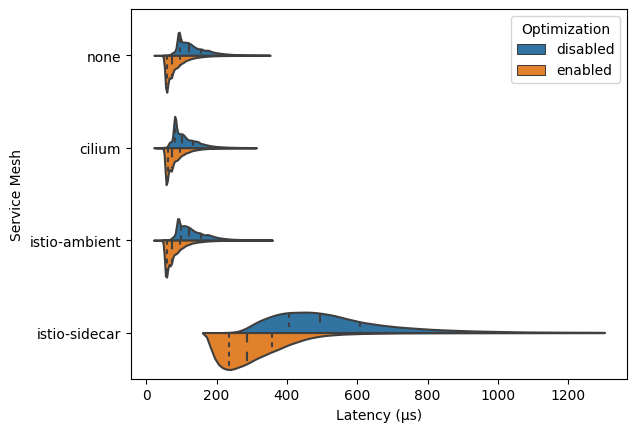

In [793]:
p99 = ping_echo.groupby('service_mesh').latency.transform(lambda x: x.quantile(0.99))

g = sns.violinplot(data=ping_echo[ping_echo.latency.lt(p99)], x='latency', y='service_mesh', hue='optimization', split=True, inner='quart', cut=0, order=service_mesh_order, hue_order=optimization_order)

g.set_xticks(g.get_xticks().tolist())
g.set(
    #title='',
    ylabel='Service Mesh',
    xlabel='Latency (µs)',
    xticklabels=[format_time(tick, 'ns', 'us') for tick in g.get_xticks()],
)

plt.legend(title='Optimization', loc='upper right')

g.figure.savefig('ping-echo-violinplot-latency-p99.svg', bbox_inches='tight')

In [139]:
summary = ping_echo_extra.groupby(['service_mesh', 'optimization'])['jitter'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_time(x, 'ns', 'us'))

summary
#print_latex(summary)

p25    p50    avg    p75
service_mesh  optimization                            
cilium        disabled       87.6   87.9   87.9   89.2
              enabled        96.0   97.4  101.3   99.4
istio-ambient disabled       99.8  102.3  101.6  103.3
              enabled        94.7  103.9  110.9  104.5
istio-sidecar disabled      276.7  278.3  278.5  279.3
              enabled       171.8  179.1  178.8  180.0
none          disabled       95.2   96.0   96.1   96.6
              enabled        92.3   95.8   94.7   97.3

/tmp/ipykernel_678127/484588023.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set(


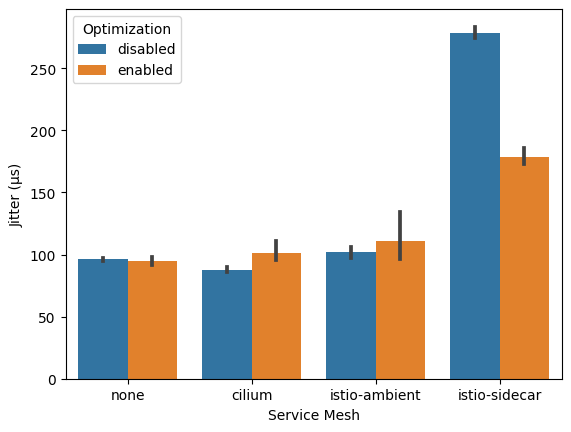

In [739]:
g = sns.barplot(data=ping_echo_extra, y='jitter', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='Jitter (µs)',
    yticklabels=[format_time(tick, 'ns', 'us') for tick in g.get_yticks()],
)

plt.legend(title='Optimization', loc='upper left')

g.figure.savefig('ping-echo-barplot-jitter.svg', bbox_inches='tight')

In [138]:
summary = ping_echo_extra.groupby(['service_mesh', 'optimization'])['fct'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_time(x, 'ns', 's'))

summary
#print_latex(summary)

p25   p50   avg   p75
service_mesh  optimization                        
cilium        disabled      12.3  12.4  12.5  12.6
              enabled        9.6   9.6   9.6   9.7
istio-ambient disabled      14.7  14.7  14.8  14.8
              enabled        9.5   9.6   9.6   9.6
istio-sidecar disabled      55.2  56.1  56.3  57.8
              enabled       32.8  33.0  32.9  33.1
none          disabled      14.5  14.8  14.6  14.8
              enabled        9.5   9.7   9.6   9.7

/tmp/ipykernel_678127/3709228891.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set(


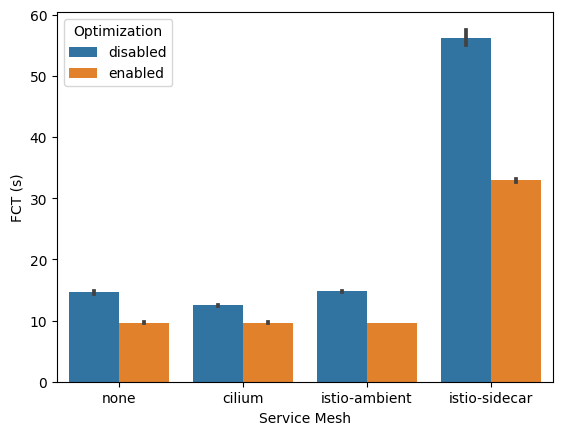

In [733]:
g = sns.barplot(data=ping_echo_extra, y='fct', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='FCT (s)',
    yticklabels=[format_time(tick, 'ns', 's') for tick in g.get_yticks()],
)

plt.legend(title='Optimization', loc='upper left')

g.figure.savefig('ping-echo-barplot-fct.svg', bbox_inches='tight')

# redis

In [120]:
redis_raw = pd.DataFrame(logs['workload_logs']['redis'])
redis_raw = redis_raw.apply(lambda x: pd.concat([x.drop('meta'), pd.json_normalize(x.meta).iloc[0]]), axis=1)

In [121]:
redis = redis_raw[redis_raw.type.eq('metrics')].drop(['iteration', 'type'], axis=1).explode('data', ignore_index=True)
redis = redis.apply(lambda x: pd.concat([x.drop('data'), pd.Series({} if pd.isna(x.data) else x.data)]), axis=1)
redis['took'] = redis.took.apply(lambda x: pd.NA if pd.isna(x) else int(x))
redis = redis.applymap(lambda x: pd.NA if pd.isna(x) else x) \
    .astype({'took': 'Int64', 'latency_avg': 'Float64', 'ops_avg': 'Float64', 'throughput_avg': 'Float64'})

/tmp/ipykernel_840423/2273434082.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  redis = redis.applymap(lambda x: pd.NA if pd.isna(x) else x) \


In [122]:
redis.head()

,cni,optimization,service_mesh,workload,iteration,took,ops_avg,throughput_avg,latency_avg
0,calico,disabled,istio-ambient,redis,1,19000000000,50057.0,17364418.6,1990000.0
1,calico,disabled,istio-ambient,redis,2,20000000000,48279.0,16777216.0,2070000.0
2,calico,disabled,istio-ambient,redis,3,20000000000,48255.0,16777216.0,2070000.0
3,calico,disabled,istio-ambient,redis,4,20000000000,48781.0,16944988.2,2050000.0
4,calico,disabled,istio-ambient,redis,5,20000000000,48314.0,16777216.0,2070000.0


In [123]:
hgrm_quantile = lambda df, q: df[df.percentile.ge(q)].iloc[0]

In [124]:
redis_hist = redis_raw[redis_raw.type.eq('histogram')].drop('type', axis=1)
def redis_hist_transform(x):
    ret = pd.read_csv(io.StringIO(x.data), sep=' +', engine='python').drop(columns='1/(1-Percentile)').rename(columns={'Value': 'latency', 'Percentile': 'percentile', 'TotalCount': 'total_count'})
    ret = x.drop('data').to_frame().T.join(ret, how='cross')
    ret['total_count_diff'] = ret.total_count - ret.total_count.shift(1, fill_value=0)
    return ret
redis_hist = redis_hist.apply(redis_hist_transform, axis=1)
redis_hist = pd.concat(redis_hist.tolist(), ignore_index=True)

In [125]:
redis_hist.head()

,cni,iteration,optimization,service_mesh,workload,latency,percentile,total_count,total_count_diff
0,calico,3,disabled,istio-ambient,redis,4.7e-02,0.0e+00,2,2
1,calico,3,disabled,istio-ambient,redis,1.2e+00,5.0e-02,51144,51142
2,calico,3,disabled,istio-ambient,redis,1.4e+00,1.0e-01,100043,48899
3,calico,3,disabled,istio-ambient,redis,1.4e+00,1.5e-01,150213,50170
4,calico,3,disabled,istio-ambient,redis,1.5e+00,2.0e-01,205650,55437


In [787]:
hgrm_quantile(redis_hist, .5)

cni                        calico
iteration                       3
optimization             disabled
service_mesh        istio-ambient
workload                    redis
latency                     1.711
percentile                    0.5
total_count                503018
total_count_diff            45321
Name: 10, dtype: object

In [137]:
summary = memory_used_bytes[memory_used_bytes.workload.eq('redis')].groupby(['service_mesh', 'optimization'])['value'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_data_size(x, 'B', 'MB'))

summary
#print_latex(summary)

p25     p50     avg     p75
service_mesh  optimization                                
cilium        disabled      1333.3  1428.9  1392.9  1434.9
              enabled       1414.9  1477.6  1452.4  1485.8
istio-ambient disabled      1637.8  1742.0  1705.2  1759.7
              enabled       1738.9  1802.5  1773.6  1813.3
istio-sidecar disabled      1765.3  1788.3  1769.7  1813.9
              enabled       1813.4  1836.1  1816.5  1860.8
none          disabled      1393.1  1464.2  1442.0  1479.4
              enabled       1466.1  1525.5  1503.4  1537.9

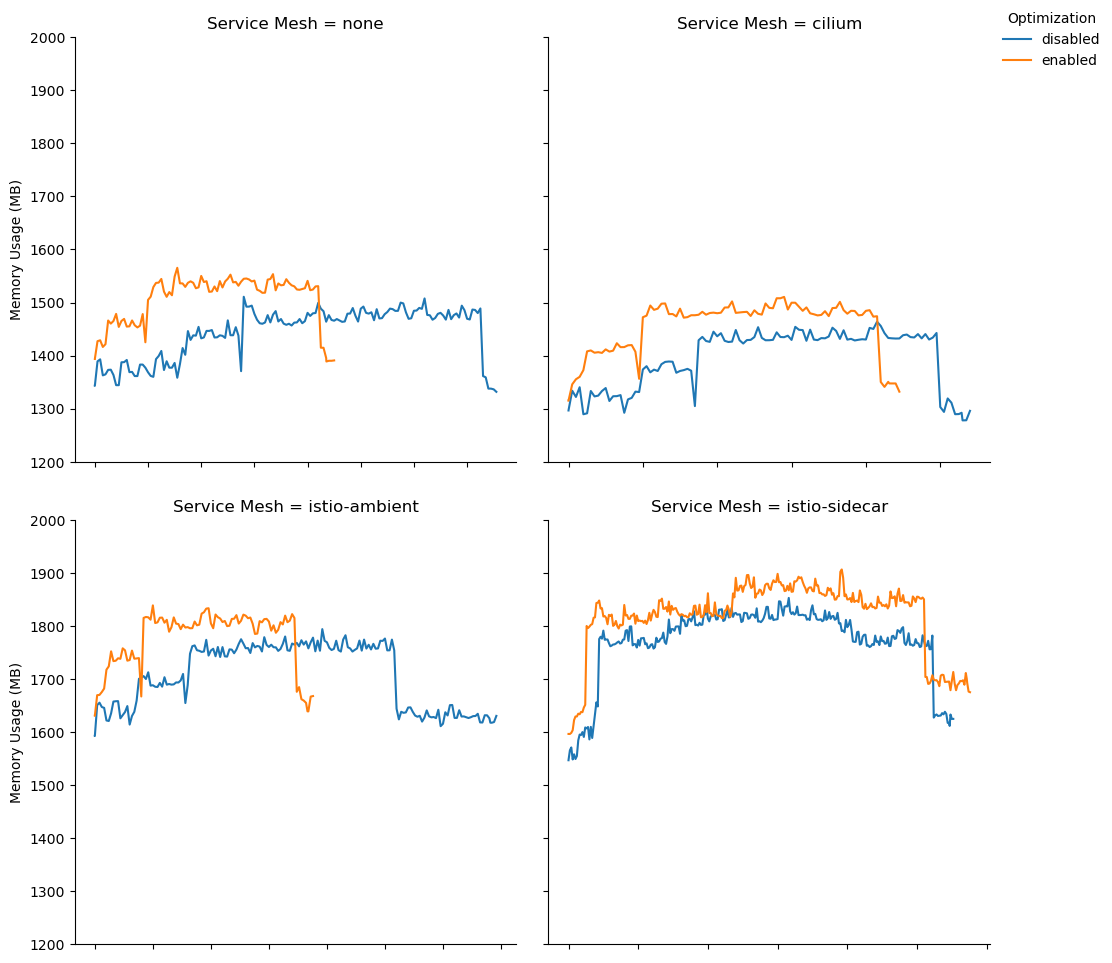

In [89]:
g = sns.relplot(kind='line', data=memory_used_bytes[memory_used_bytes.workload.eq('redis')], y='value', x='timestamp_start', hue='optimization', col='service_mesh', col_order=service_mesh_order, col_wrap=2, facet_kws={'sharey': True, 'sharex': False})

for ax in g.axes:
    ax.set_yticks(ax.get_yticks().tolist())
    ax.set(
        title=ax.get_title().replace('service_mesh', 'Service Mesh'),
        xlabel='',
        ylabel='Memory Usage (MB)',
        yticklabels=[format_data_size(tick, 'B', 'MB') for tick in ax.get_yticks()],
        xticklabels=[],
    )

g.legend.set(title='Optimization', loc='upper right')
#g.get_legend().set_visible(False)
g.figure.savefig('redis-relplot-line-memory-used-bytes.svg', bbox_inches='tight')

In [136]:
summary = redis.groupby(['service_mesh', 'optimization'])['ops_avg'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
)

summary
#print_latex(summary)

p25      p50      avg      p75
service_mesh  optimization                                    
cilium        disabled      69571.0  70428.0  70332.6  70701.0
              enabled       70866.0  71332.0  71566.4  71756.0
istio-ambient disabled      48279.0  48314.0  48737.2  48781.0
              enabled       67252.0  67290.0  67553.6  67577.0
istio-sidecar disabled      17450.0  17528.5  17542.5  17621.0
              enabled       17072.8  17232.0  17305.2  17464.5
none          disabled      47902.0  48005.0  48248.8  48594.0
              enabled       69583.0  70765.0  70342.8  71096.0

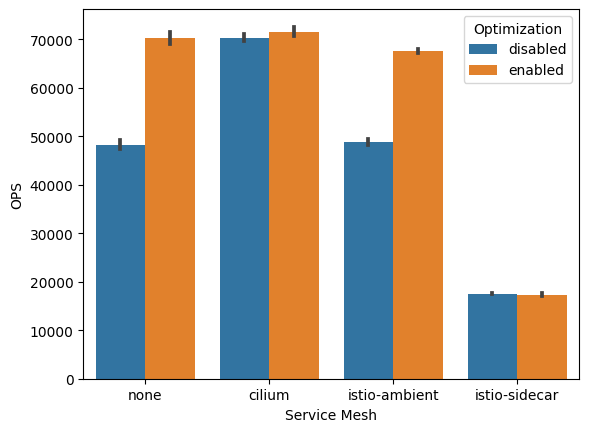

In [789]:
g = sns.barplot(data=redis, y='ops_avg', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='OPS',
    #yticklabels=[],
)

plt.legend(title='Optimization', loc='upper right')

g.figure.savefig('redis-barplot-ops.svg', bbox_inches='tight')

In [790]:
redis.groupby(['service_mesh', 'optimization'])['throughput_avg'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).applymap(lambda x: format_data_size(x, 'b', 'MB'))

p25       p50       avg       p75
service_mesh  optimization                                        
cilium        disabled      3.019899  3.061842  3.055550  3.072328
              enabled       3.082813  3.093299  3.107979  3.114271
istio-ambient disabled      2.097152  2.097152  2.116026  2.118124
              enabled       2.925527  2.925527  2.936013  2.936013
istio-sidecar disabled      0.757993  0.761405  0.762002  0.765414
              enabled       0.741596  0.748513  0.751695  0.758612
none          disabled      2.076180  2.086666  2.095055  2.107638
              enabled       3.019899  3.072328  3.055550  3.093299

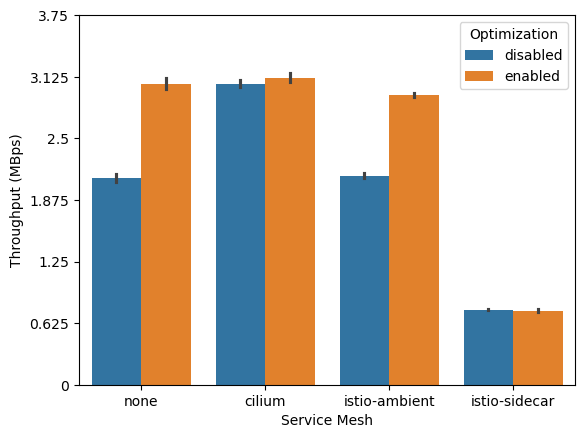

In [230]:
g = sns.barplot(data=redis, y='throughput_avg', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='Throughput (MBps)',
    yticklabels=[format_data_size(tick, 'b', 'MB') for tick in g.get_yticks()],
)

plt.legend(title='Optimization', loc='upper right')

g.figure.savefig('redis-barplot-throughput.svg', bbox_inches='tight')

In [135]:
summary = redis.groupby(['service_mesh', 'optimization'])['latency_avg'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_time(x, 'ns', 'ms'))

summary
#print_latex(summary)

p25  p50  avg  p75
service_mesh  optimization                    
cilium        disabled      1.4  1.4  1.4  1.4
              enabled       1.4  1.4  1.4  1.4
istio-ambient disabled      2.0  2.1  2.0  2.1
              enabled       1.5  1.5  1.5  1.5
istio-sidecar disabled      5.7  5.7  5.7  5.7
              enabled       5.7  5.8  5.8  5.8
none          disabled      2.0  2.1  2.1  2.1
              enabled       1.4  1.4  1.4  1.4

/tmp/ipykernel_678127/2602547844.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set(


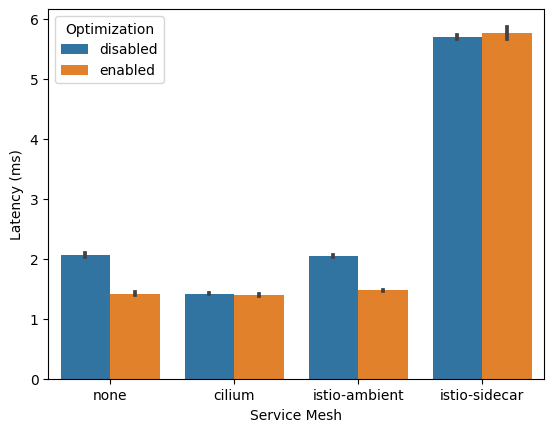

In [720]:
g = sns.barplot(data=redis, y='latency_avg', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='Latency (ms)',
    yticklabels=[format_time(tick, 'ns', 'ms') for tick in g.get_yticks()],
)

plt.legend(title='Optimization', loc='upper left')

g.figure.savefig('redis-barplot-latency.svg', bbox_inches='tight')

In [134]:
summary = redis.groupby(['service_mesh', 'optimization'])['took'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_time(x, 'ns', 's'))

summary
#print_latex(summary)

p25   p50   avg p75
service_mesh  optimization                      
cilium        disabled        14    14  13.8  14
              enabled         13    14  13.6  14
istio-ambient disabled        20    20  19.8  20
              enabled         14    14    14  14
istio-sidecar disabled        56  56.5  56.5  57
              enabled       56.8  57.5  57.2  58
none          disabled        20    20  20.2  20
              enabled         14    14  13.8  14

/tmp/ipykernel_678127/3921868213.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set(


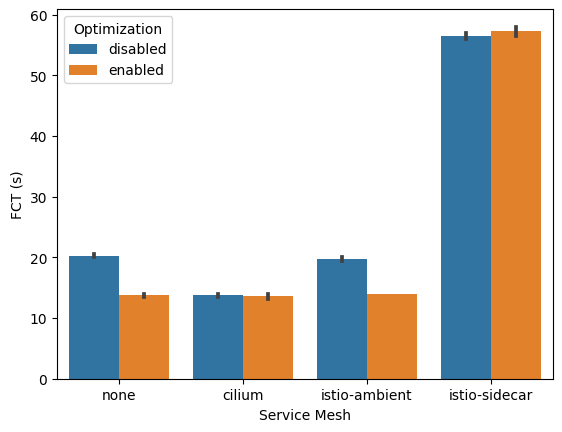

In [724]:
g = sns.barplot(data=redis, y='took', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='FCT (s)',
    yticklabels=[format_time(tick, 'ns', 's') for tick in g.get_yticks()],
)

plt.legend(title='Optimization', loc='upper left')

g.figure.savefig('redis-barplot-fct.svg', bbox_inches='tight')

In [174]:
redis_hist.head()

,cni,service_mesh,optimization,workload,iteration,latency,percentile,total_count
0,calico,istio-ambient,disabled,redis,3,0.047,0.0,2
1,calico,istio-ambient,disabled,redis,3,1.215,0.05,51144
2,calico,istio-ambient,disabled,redis,3,1.375,0.1,100043
3,calico,istio-ambient,disabled,redis,3,1.439,0.15,150213
4,calico,istio-ambient,disabled,redis,3,1.487,0.2,205650


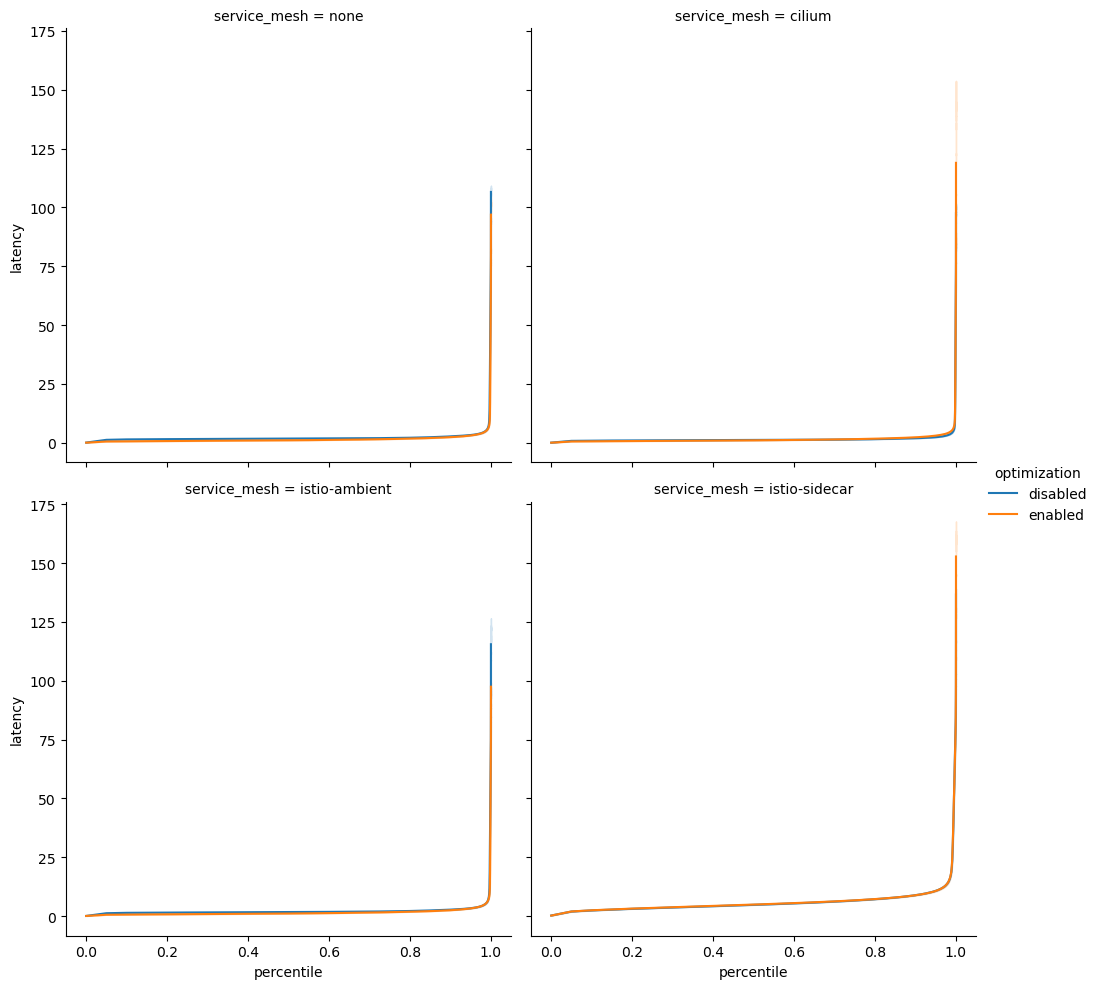

In [155]:
g = sns.relplot(
    data=redis_hist, x='percentile', y='latency',
    col='service_mesh', col_wrap=2, col_order=service_mesh_order, hue='optimization',
    kind='line'
)

#for ax in g.axes:
#    service_mesh = ax.get_title().replace('service_mesh = ', '')
#    ax.set_title(f'Service Mesh = {service_mesh}')
#    p99 = hgrm_quantile(redis_hist[redis_hist.service_mesh.eq(service_mesh)], .99).latency
#    ax.axvline(.99, linestyle='--', color='r', label=f'{service_mesh} = {p99}')

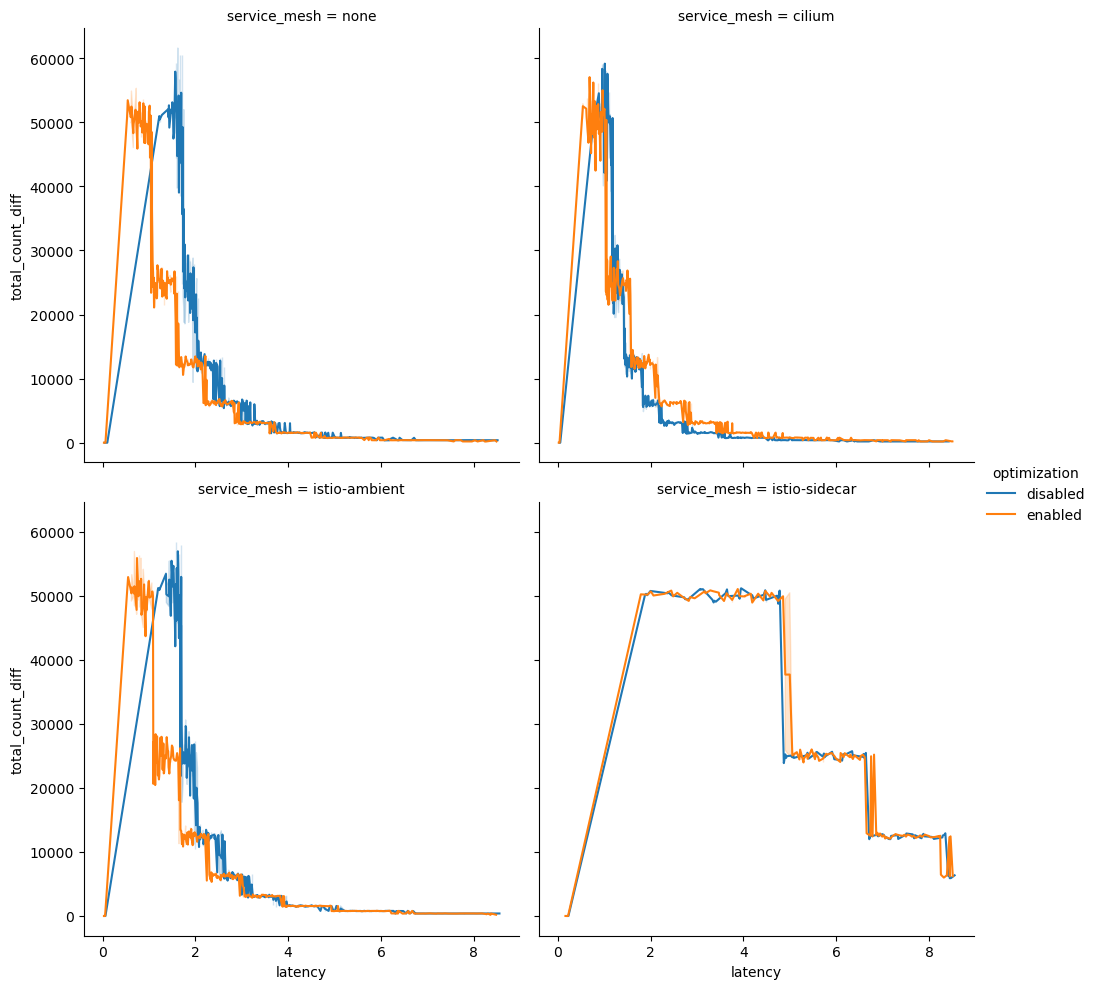

In [147]:
sns.relplot(
    data=redis_hist[redis_hist.latency.le(hgrm_quantile(redis_hist, .995).latency)], y='total_count_diff', x='latency',
    col='service_mesh', col_wrap=2, col_order=service_mesh_order, hue='optimization',
    kind='line'
)